In [1]:
import sys
sys.path.append('../')

import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import time

from glob import glob
from scipy.optimize import linear_sum_assignment
from tqdm import tqdm

from utils import show_test_images

In [2]:
image_dir = f'/storage/annajiwons/images'
merfish_dir = f'{image_dir}/merfish'

# Load images and masks

In [3]:
# Load images in train and test dirs
merfish_image_names = glob(f'{merfish_dir}/test/images/*.tif')
merfish_image_names.extend(glob(f'{merfish_dir}/train/images/*.tif'))
merfish_image_names.sort(key=lambda name: name[-6:])
merfish_images = [cv.imread(img) for img in merfish_image_names]

In [4]:
# Load masks in train and test dirs
merfish_mask_names = glob(f'{merfish_dir}/test/masks/*.tif')
merfish_mask_names.extend(glob(f'{merfish_dir}/train/masks/manual/*.tif'))
merfish_mask_names.sort(key=lambda name: name[-6:])
merfish_masks = [cv.imread(img, cv.IMREAD_UNCHANGED) for img in merfish_mask_names]

# OpenCV Watershed on a demo image
Try using watershed from OpenCV with a demo image. OpenCV's watershed uses marker-based watershed - adapted from: https://docs.opencv.org/master/d3/db4/tutorial_py_watershed.html

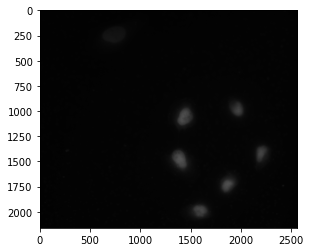

In [11]:
demo_img = merfish_images[7]
plt.imshow(demo_img);

# Convert to 8bit grayscale
demo_img_gray = cv.cvtColor(demo_img, cv.COLOR_BGR2GRAY)

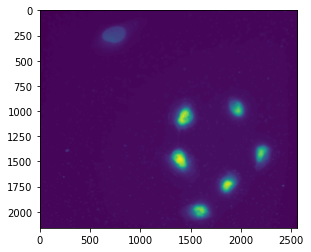

In [12]:
# Median filtering to remove noise
demo_img_gray_filter = cv.medianBlur(demo_img_gray, 7)
plt.imshow(demo_img_gray_filter);

9.0


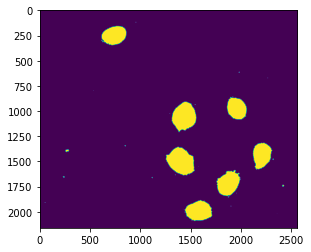

In [13]:
# Threshold foreground and background using Triangle thresholding
thresh_val, thresh_img = cv.threshold(demo_img_gray_filter, 0, 255, cv.THRESH_TRIANGLE)
print(thresh_val)
plt.imshow(thresh_img);

In [14]:
# Remove noise further using Opening morphological operation
kernel = np.ones((3,3), np.uint8)
opening = cv.morphologyEx(thresh_img, cv.MORPH_OPEN, kernel, iterations = 2)

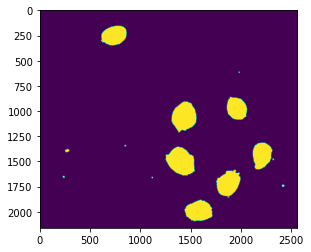

In [15]:
# Find area that is sure to be background using dilate
background = cv.dilate(opening, kernel, iterations=3)
plt.imshow(background);

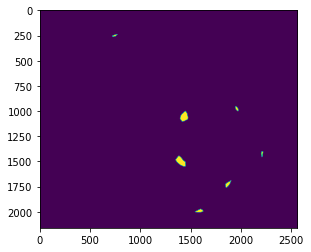

In [17]:
# Find area that is sure to be the foreground
dist_transform = cv.distanceTransform(opening,cv.DIST_L2, 5)
_, foreground = cv.threshold(dist_transform, 0.7 * dist_transform.max(), 255, cv.THRESH_BINARY)
plt.imshow(foreground);

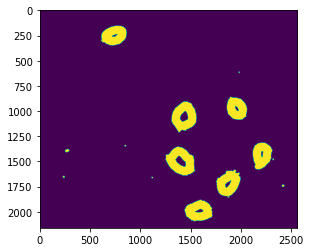

In [18]:
# Find area that is left, which is unknown to be foreground or background
foreground = np.uint8(foreground)
unknown = cv.subtract(background, foreground)
plt.imshow(unknown);

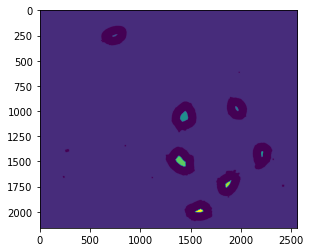

In [19]:
# Marker labelling
_, markers = cv.connectedComponents(foreground)

# Add one to all labels so that sure background is not 0, but 1
markers = markers + 1

# Now, mark the region of unknown with zero
markers[unknown == 255] = 0

plt.imshow(markers);

The unknown regions are marked in the deep purple, and the background is labelled with the lighter purple. The rest are labelled per each connected component.

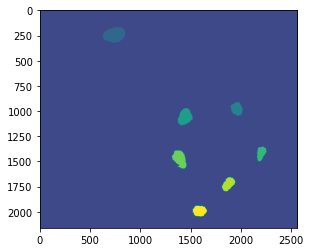

In [20]:
# Watershed
markers = cv.watershed(demo_img, markers)
plt.imshow(markers);

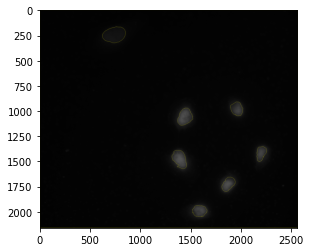

In [21]:
# Show boundaries on original image
demo_img[markers == -1] = [255,255,0]
plt.imshow(demo_img);

The `watershed` function returns an image in which pixels are labelled with the original seed values or -1 for boundary regions.

For ease of calculation of IoU, set all the -1 regions to 1 (which represents background), then subtract 1 from all values to get the original labelling.

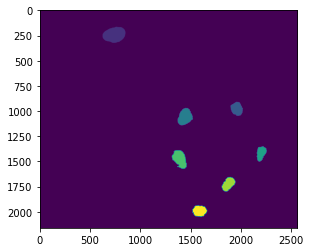

In [22]:
markers[markers == -1] = 1
markers -= 1
plt.imshow(markers);

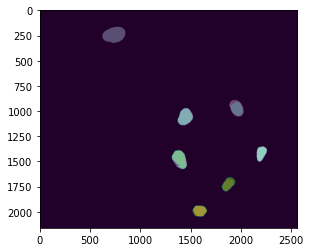

In [23]:
# Show the mask image with the result overlayed
plt.imshow(merfish_masks[7], cmap=plt.cm.gray);
plt.imshow(markers, alpha=0.5);

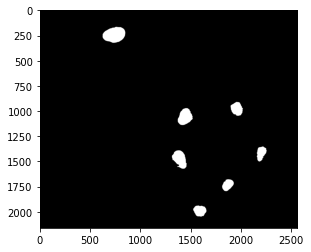

In [24]:
# Get intersection between result and mask
intersection = np.logical_and(markers, merfish_masks[7])
plt.imshow(intersection, cmap=plt.cm.gray);

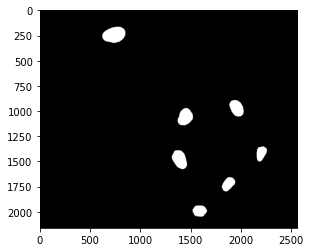

In [25]:
# Get union between result and mask
union = np.logical_or(markers, merfish_masks[7])
plt.imshow(union, cmap=plt.cm.gray);

In [26]:
# IoU for entire image
iou = np.sum(intersection) / np.sum(union)
print(iou)

0.8674261826473455


# Evaluate results

To get the true positive values, use the same method used in StarDist: if a predicted object has a corresponding ground truth object with a IoU value greater than a threshold, consider it a true positive.

Adapted from StarDist: https://github.com/mpicbg-csbd/stardist/blob/0c737544a05ae3f6b60667516d2d25e0cebef265/stardist/matching.py


In [5]:
def get_confusion_matrix_vals(true, pred, thresholds):
    """
    TODO: write doc, assumes true and pred have same labels, returns dict with {thresh: (tp, fp, fn)} 
    """
    x = true.copy().ravel()
    y = pred.copy().ravel()

    # Get overlapping counts between x and y
    m, n = 1 + x.max(), 1 + y.max()
    overlap = np.zeros((m, n), dtype=np.uint)
    np.add.at(overlap.ravel(), x * n + y, 1)
    
    # Get matrix of IoU values for each pair of labels
    if np.sum(overlap) != 0:
        n_pixels_pred = np.sum(overlap, axis=0, keepdims=True)
        n_pixels_true = np.sum(overlap, axis=1, keepdims=True)
        scores = overlap / (n_pixels_pred + n_pixels_true - overlap)
    else:
        scores = overlap
    
    scores = scores[1:,1:]
    n_true, n_pred = scores.shape
    n_matched = min(n_true, n_pred)

    cm_vals = {}
    
    for thresh in thresholds:
        # Get best pair matches and print IoU scores for each
        if n_matched > 0 and np.any(scores >= thresh):
            costs = -(scores >= thresh).astype(float) - scores / (2 * n_matched)
            true_ind, pred_ind = linear_sum_assignment(costs)
            match_ok = scores[true_ind, pred_ind] >= thresh
            tp = np.count_nonzero(match_ok)
        else:
            tp = 0
        
        fp = n_pred - tp
        fn = n_true - tp

        cm_vals[thresh] = (tp, fp, fn)

    return cm_vals

In [72]:
get_confusion_matrix_vals(merfish_masks[7], markers, [0.5])

{0.5: (7, 0, 0)}

# Run method on all images

Now, extract what has been done so far in to a function so that it can be run on all images.

In [94]:
def watershed_seg(img, blur_ksize = 5, morph_kernel = None, opening_itr = 2, dilate_itr = 3, foreground_thresh_ratio = 0.5, zero_boundaries = True, show_step_images = False):
    if show_step_images:
        figure, figure_axes = plt.subplots(2, 4, figsize=(24, 6))

    # Convert to 8bit grayscale
    img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

    # Median filtering to remove noise
    img_gray_filter = cv.medianBlur(img_gray, blur_ksize)

    if show_step_images:
        figure_axes[0][0].imshow(img_gray_filter)
        figure_axes[0][0].set_title(f'After median filtering ksize = {blur_ksize}')

    # Threshold foreground and background using Triangle thresholding
    thresh_val, thresh_img = cv.threshold(img_gray_filter, 0, 255, cv.THRESH_TRIANGLE)

    if show_step_images:
        figure_axes[0][1].imshow(thresh_img)
        figure_axes[0][1].set_title(f'After Triangle Thresholding')

    # Remove noise further using Opening morphological operation
    kernel = np.ones((3,3), np.uint8) if morph_kernel is None else morph_kernel
    opening = cv.morphologyEx(thresh_img, cv.MORPH_OPEN, kernel, iterations = opening_itr)

    if show_step_images:
        figure_axes[0][2].imshow(opening)
        figure_axes[0][2].set_title(f'After morph open')

    # Find area that is sure to be background using dilate
    background = cv.dilate(opening, kernel, iterations = dilate_itr)

    if show_step_images:
        figure_axes[0][3].imshow(background)
        figure_axes[0][3].set_title(f'After dilate')

    # Find area that is sure to be the foreground
    dist_transform = cv.distanceTransform(opening, cv.DIST_L2, 5)
    _, foreground = cv.threshold(dist_transform, foreground_thresh_ratio * dist_transform.max(), 255, cv.THRESH_BINARY)

    if show_step_images:
        figure_axes[1][0].imshow(foreground)
        figure_axes[1][0].set_title(f'Foreground')

    # Find area that is left, which is unknown to be foreground or background
    foreground = np.uint8(foreground)
    unknown = cv.subtract(background, foreground)

    if show_step_images:
        figure_axes[1][1].imshow(unknown)
        figure_axes[1][1].set_title(f'Unknown')

    # Marker labelling
    _, markers = cv.connectedComponents(foreground)

    # Add 1 to all labels so that sure background is not 0, but 1
    markers = markers + 1

    # Now, mark the region of unknown with zero
    markers[unknown == 255] = 0

    # Watershed
    markers = cv.watershed(img, markers)

    # Restore label values by subtracting 1, and zero out boundaries if option selected
    markers -= 1
    if zero_boundaries:
        markers[markers == -2] = 0
    else:
        markers[markers == -2] = -1

    if show_step_images:
        figure_axes[1][2].imshow(markers)
        figure_axes[1][2].set_title(f'Final Result')
    return markers


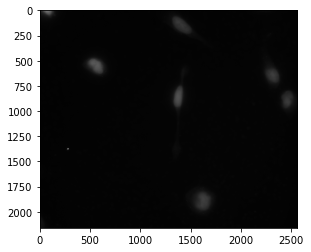

In [37]:
# Test above on demo image
demo_img_2 = merfish_images[11]
plt.imshow(demo_img_2);

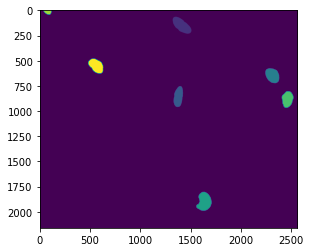

In [62]:
demo_img_2_mask = merfish_masks[11]
plt.imshow(demo_img_2_mask);

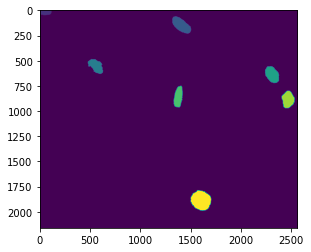

In [63]:
demo_img_2_res = watershed_seg(demo_img_2)
plt.imshow(demo_img_2_res);

In [73]:
get_confusion_matrix_vals(demo_img_2_mask, demo_img_2_res, [0.6, 0.7, 0.8, 0.9])

{0.6: (5, 2, 2), 0.7: (5, 2, 2), 0.8: (5, 2, 2), 0.9: (2, 5, 5)}

In [85]:
taus = [0.6, 0.7, 0.8, 0.9]
tp_total = {key: 0 for key in taus}
fp_total = {key: 0 for key in taus}
fn_total = {key: 0 for key in taus}

result_imgs = []

for i in tqdm(range(len(merfish_images))):
    watershed_res = watershed_seg(merfish_images[i])
    result_imgs.append(watershed_res)

    cm_vals = get_confusion_matrix_vals(merfish_masks[i], watershed_res, taus)
    print(f'image {i}: {cm_vals}')
    for tau in taus:
        tp_total[tau] += cm_vals[tau][0]
        fp_total[tau] += cm_vals[tau][1]
        fn_total[tau] += cm_vals[tau][2]

print(f'tp_total = {tp_total}, fp_total = {fp_total}, fn_total = {fn_total}')

100%|██████████| 42/42 [16:31<00:00, 23.61s/it]image 41: {0.6: (3, 2, 5), 0.7: (1, 4, 7), 0.8: (1, 4, 7), 0.9: (1, 4, 7)}
tp_total = {0.6: 160, 0.7: 142, 0.8: 109, 0.9: 56}, fp_total = {0.6: 43, 0.7: 61, 0.8: 94, 0.9: 147}, fn_total = {0.6: 49, 0.7: 67, 0.8: 100, 0.9: 153}



In [86]:
for tau in taus:
    tp = tp_total[tau]
    fp = fp_total[tau]
    fn = fn_total[tau]

    f1_score = (2 * tp) / (2 * tp + fp + fn) if tp > 0 else 0
    print(f'f1 score for tau = {tau}: {f1_score}')

    avg_precision = tp / (tp + fn + fp) if tp > 0 else 0
    print(f'average precision for tau = {tau}: {avg_precision}')

f1 score for tau = 0.6: 0.7766990291262136
average precision for tau = 0.6: 0.6349206349206349
f1 score for tau = 0.7: 0.6893203883495146
average precision for tau = 0.7: 0.5259259259259259
f1 score for tau = 0.8: 0.529126213592233
average precision for tau = 0.8: 0.35973597359735976
f1 score for tau = 0.9: 0.27184466019417475
average precision for tau = 0.9: 0.15730337078651685


# Poor Result Example 1.

Now, show some examples of poor segmentation and why it doesn't work well:

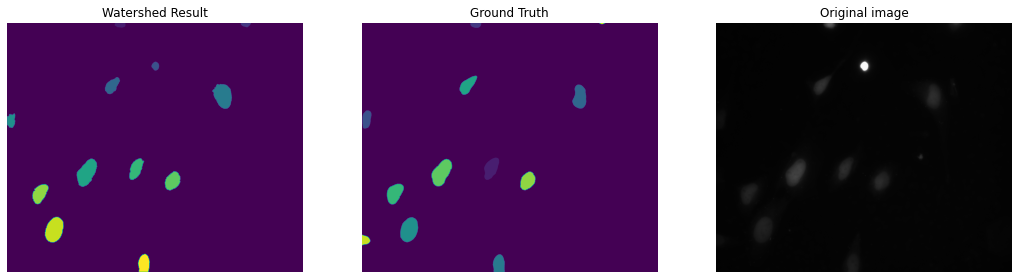

In [101]:
figure, figure_axes = plt.subplots(1, 3, figsize=(18, 6))
figure_axes[0].imshow(result_imgs[29])
figure_axes[0].set_title('Watershed Result')
figure_axes[0].axis('off')

figure_axes[1].imshow(merfish_masks[29])
figure_axes[1].set_title('Ground Truth')
figure_axes[1].axis('off')

figure_axes[2].imshow(merfish_images[29])
figure_axes[2].set_title('Original image')
figure_axes[2].axis('off');

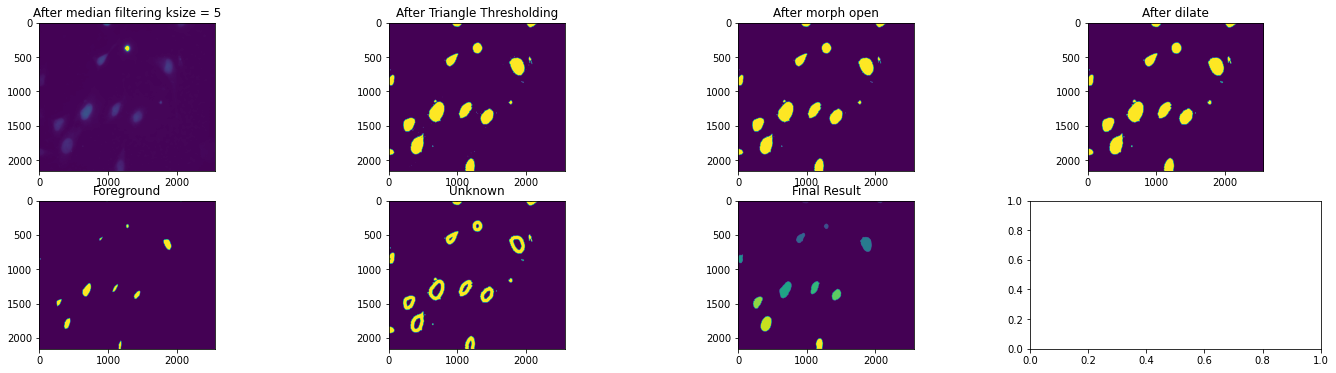

In [111]:
watershed_seg(merfish_images[29], show_step_images = True);

For this image, watershed missed a nucleus in the lower left. That nucleus is quite dark, so increasing contrast in the overall image may help.


It also considered the bright spot as a nucleus. Threshold high values:

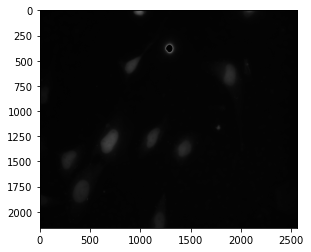

In [112]:
# Threshold values that are too bright
img = np.copy(merfish_images[29])
img[img > 190] = 0
plt.imshow(img);

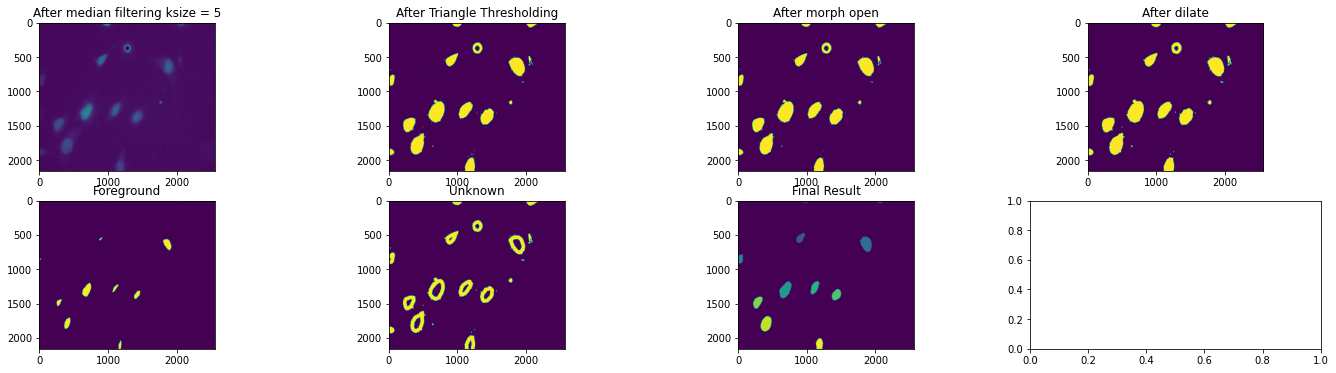

In [113]:
watershed_seg(img, show_step_images = True);

# Poor Result Example 2.

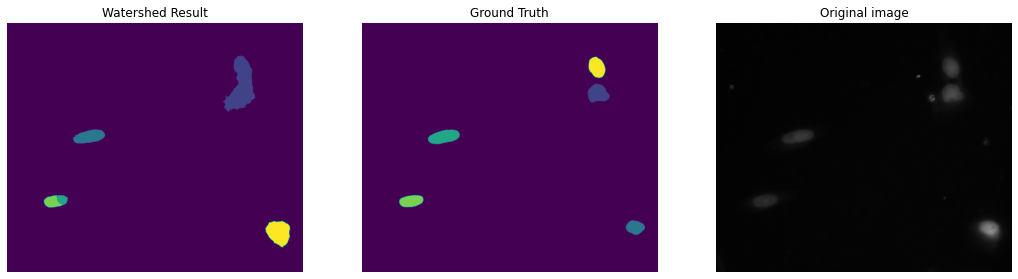

In [102]:
figure, figure_axes = plt.subplots(1, 3, figsize=(18, 6))
figure_axes[0].imshow(result_imgs[17])
figure_axes[0].set_title('Watershed Result')
figure_axes[0].axis('off')

figure_axes[1].imshow(merfish_masks[17])
figure_axes[1].set_title('Ground Truth')
figure_axes[1].axis('off')

figure_axes[2].imshow(merfish_images[17])
figure_axes[2].set_title('Original image')
figure_axes[2].axis('off');

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)

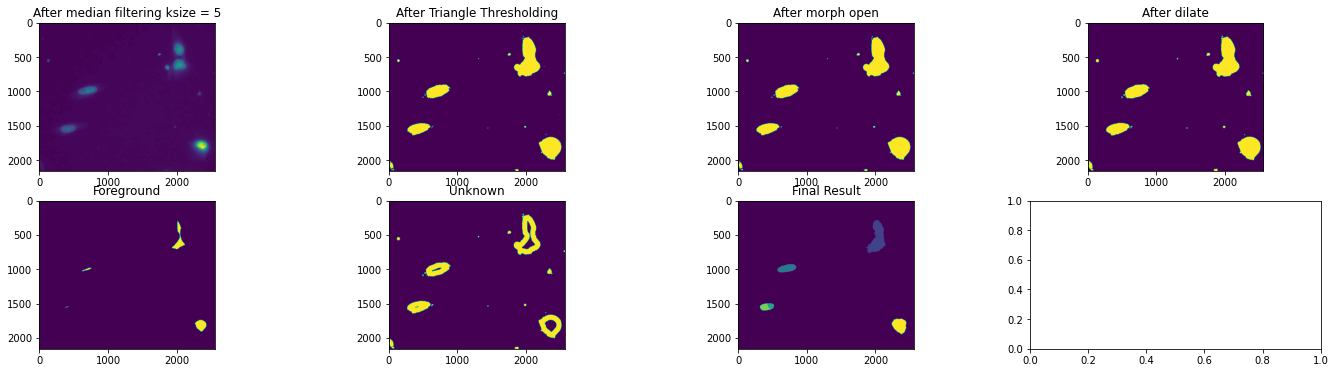

In [120]:
# Look at which steps resulted in merging at the top right and splitting at the bottom left
watershed_seg(merfish_images[17], show_step_images = True)

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)

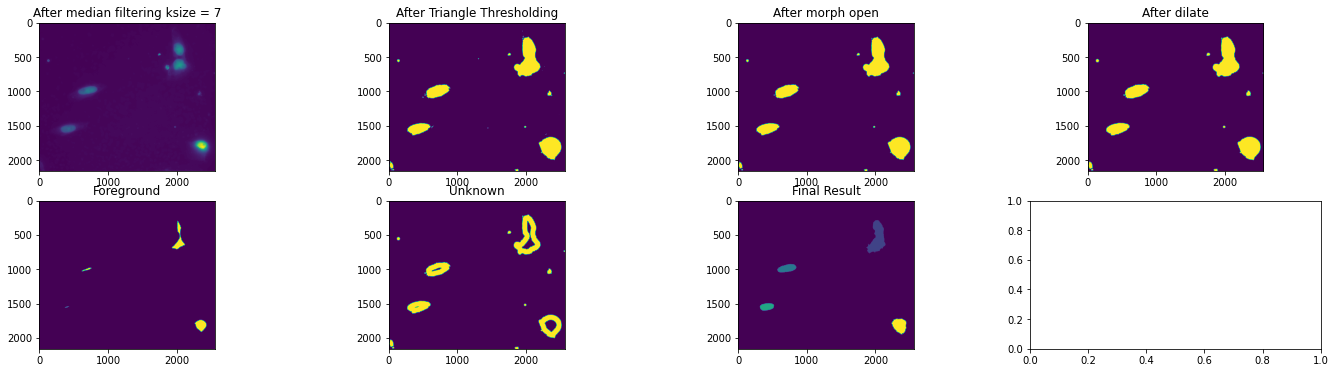

In [121]:
# Try blurring more, and increasing iterations of morph open
watershed_seg(merfish_images[17], blur_ksize = 7, opening_itr = 4, show_step_images = True)

The bottom left nucleus was detected as two in this case. Above, you can see that there is a seed right next to that nucleus that is resulting in two nuclei. The "specks" in the image could be further removed by more blurring, thresholding of nucleus size, or more iterations of morph open.

The two top right nuclei were detected as one in this case. The threshold method worked poorly for this image. With Otsu the thresholding looks better, but Otsu didn't work well for other images. Possible ways to fix this might be to narrow the brightness range of the foreground.

Try adaptive thresholding instead of global:

In [56]:
def adapt_thresh(img, adaptiveMethod, blockSize, sub_const):
    # Convert to 8bit grayscale
    img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

    # Median filtering to remove noise
    img_gray_filter = cv.medianBlur(img_gray, 5)

    # Threshold foreground and background using adaptive gaussian thresholding
    thresh_img = cv.adaptiveThreshold(img_gray_filter, 255, adaptiveMethod, cv.THRESH_BINARY, blockSize, sub_const)

    return thresh_img


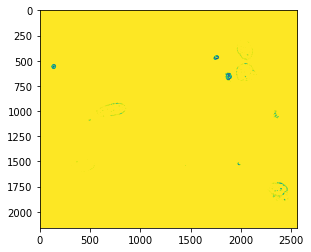

In [67]:
res = adapt_thresh(merfish_images[17], cv.ADAPTIVE_THRESH_MEAN_C, 11, 2)
plt.imshow(res);

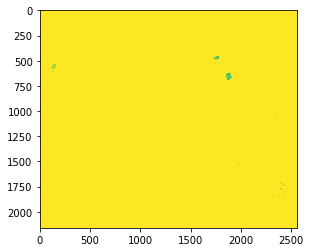

In [83]:
res = adapt_thresh(merfish_images[17], cv.ADAPTIVE_THRESH_GAUSSIAN_C, 11, 2)
plt.imshow(res);

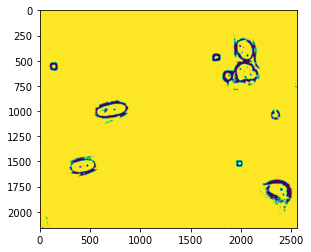

In [69]:
res = adapt_thresh(merfish_images[17], cv.ADAPTIVE_THRESH_MEAN_C, 55, 2)
plt.imshow(res);

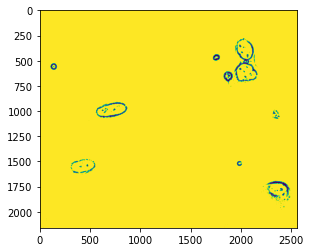

In [84]:
res = adapt_thresh(merfish_images[17], cv.ADAPTIVE_THRESH_GAUSSIAN_C, 55, 2)
plt.imshow(res);

Local thresholding can produce the edges, and then they can later be filled, but for these images I'll keep it to global thresholding since it usually produces good results.

# Poor Result Example 3.

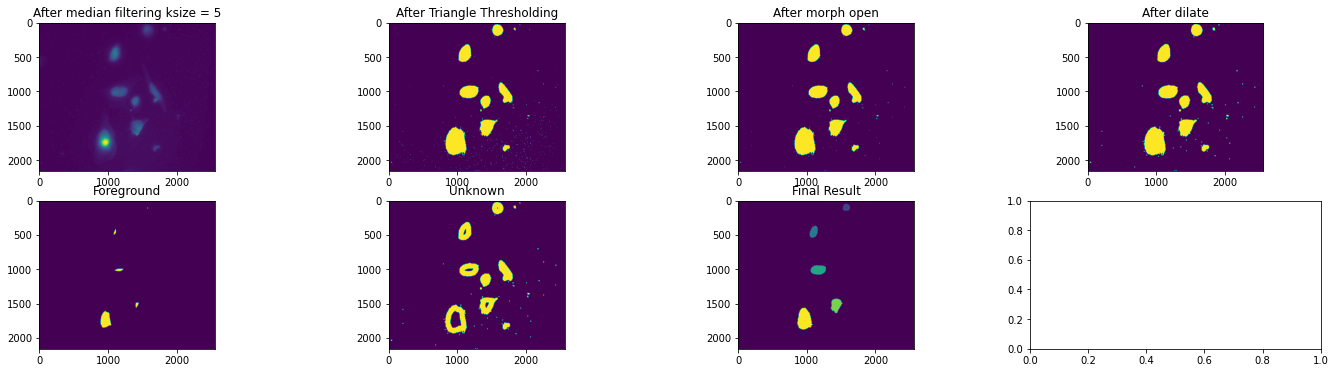

In [125]:
img = np.copy(merfish_images[41])
watershed_seg(img, show_step_images = True);

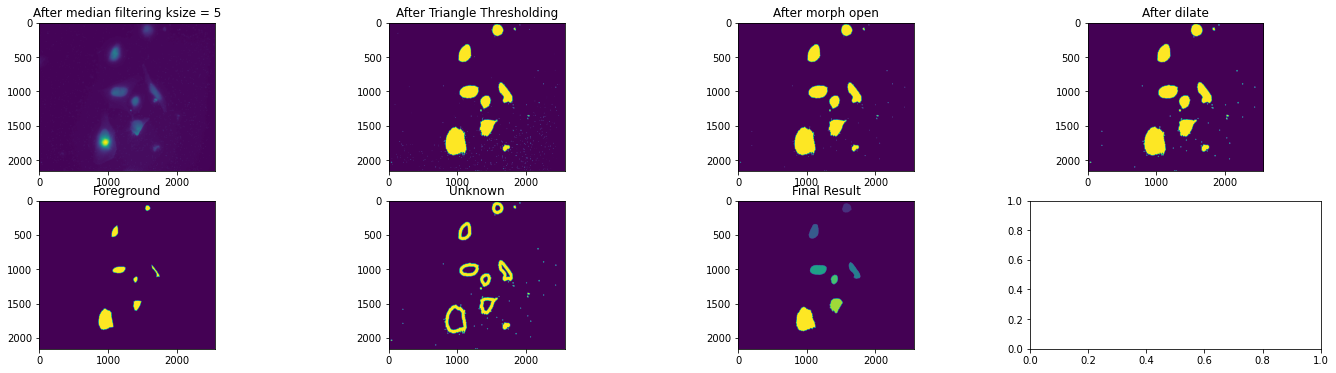

In [135]:
# Try using lower foreground thresh ratio
watershed_seg(img, foreground_thresh_ratio = 0.3, show_step_images = True);

# Tuning parameters

Instead of manually tuning the parameters for this dataset, I'll try automatically tuning to find the best parameters. The tunable parameters are the following (includes previous parameters + some more): 

- upper_limit (int): upper threshold for brightness
- alpha (int): alpha value to control contrast
- beta (int): beta value to control brightness
- blur_ksize (int): median blur kernel size side length, must be odd and > 1
- thresh_method (cv.THRESH_TRIANGLE or cv.THRESH_OTSU)
- morph_kernel (int[][]): kernel of ones for morphological operations
- opening_itr (int): number of iterations to do morphological open operation to remove noise
- dilate_itr (int): number of itereations to do morphological dilate operation to find background
- foreground_thresh_ratio (float): proportion of max distances to background that will be considered the threshold for foreground

In addition, code to show progress images will be removed to make it run faster:

In [6]:
def watershed_seg(img, upper_limit, alpha, beta, blur_ksize, thresh_method, morph_kernel, opening_itr, dilate_itr, foreground_thresh_ratio, zero_boundaries):

    # Convert to 8bit grayscale
    img_gray = cv.cvtColor(np.copy(img), cv.COLOR_BGR2GRAY)

    # Remove pixels that are above the upper_limit
    img_gray[img_gray > upper_limit] = 0

    # Adjust brightness and contrast
    img_gray = cv.convertScaleAbs(img_gray, alpha = alpha, beta = beta)

    # Median filtering to remove noise
    img_gray_filter = cv.medianBlur(img_gray, blur_ksize)

    # Threshold foreground and background using Triangle thresholding
    thresh_val, thresh_img = cv.threshold(img_gray_filter, 0, 255, cv.THRESH_TRIANGLE)

    # Remove noise further using Opening morphological operation
    kernel = np.ones((3,3), np.uint8) if morph_kernel is None else morph_kernel
    opening = cv.morphologyEx(thresh_img, cv.MORPH_OPEN, kernel, iterations = opening_itr)

    # Find area that is sure to be background using dilate
    background = cv.dilate(opening, kernel, iterations = dilate_itr)

    # Find area that is sure to be the foreground
    dist_transform = cv.distanceTransform(opening, cv.DIST_L2, 5)
    _, foreground = cv.threshold(dist_transform, foreground_thresh_ratio * dist_transform.max(), 255, cv.THRESH_BINARY)

    # Find area that is left, which is unknown to be foreground or background
    foreground = np.uint8(foreground)
    unknown = cv.subtract(background, foreground)

    # Marker labelling
    _, markers = cv.connectedComponents(foreground)

    # Add 1 to all labels so that sure background is not 0, but 1
    markers = markers + 1

    # Now, mark the region of unknown with zero
    markers[unknown == 255] = 0

    # Watershed
    markers = cv.watershed(img, markers)

    # Restore label values by subtracting 1, and zero out boundaries if option selected
    markers -= 1
    if zero_boundaries:
        markers[markers == -2] = 0
    else:
        markers[markers == -2] = -1
    return markers


## Grid Search

In [7]:
from sklearn.model_selection import ParameterGrid

In [8]:
param_grid = {'upper_limit': np.random.randint(230, 257, size = 5),
              'alpha': [0.5, 1, 1.5, 2],
              'beta': [0, 5, 10, 15, 20],
              'blur_ksize': [3, 5, 7, 9, 11], 
              'thresh_method': [cv.THRESH_TRIANGLE, cv.THRESH_OTSU],
              'morph_kernel': [np.ones((2,2), np.uint8), np.ones((3,3), np.uint8), np.ones((4,4), np.uint8), np.ones((5,5), np.uint8), np.ones((6,6), np.uint8)],
              'opening_itr': [1, 2, 3, 4, 5],
              'dilate_itr': [1, 2, 3, 4, 5],
              'foreground_thresh_ratio': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]}

In [9]:
grid = ParameterGrid(param_grid)
len(grid)

1406250

In [10]:
def evaluate_all(imgs, masks, params):
    taus = [0.6, 0.7, 0.8, 0.9]
    tp_total = {key: 0 for key in taus}
    fp_total = {key: 0 for key in taus}
    fn_total = {key: 0 for key in taus}

    upper_limit = params['upper_limit']
    alpha = params['alpha']
    beta = params['beta']
    blur_ksize = params['blur_ksize']
    thresh_method = params['thresh_method']
    morph_kernel = params['morph_kernel']
    opening_itr = params['opening_itr']
    dilate_itr = params['dilate_itr']
    foreground_thresh_ratio = params['foreground_thresh_ratio']

    for i in range(len(imgs)):
        res = watershed_seg(imgs[i], upper_limit = upper_limit, alpha = alpha, beta = beta, blur_ksize = blur_ksize, 
                            thresh_method = thresh_method, morph_kernel = morph_kernel, opening_itr = opening_itr, 
                            dilate_itr = dilate_itr, foreground_thresh_ratio = foreground_thresh_ratio, zero_boundaries = True)

        cm_vals = get_confusion_matrix_vals(masks[i], res, taus)

        for tau in taus:
            tp_total[tau] += cm_vals[tau][0]
            fp_total[tau] += cm_vals[tau][1]
            fn_total[tau] += cm_vals[tau][2]
    return tp_total, fp_total, fn_total

In [11]:
# TODO: replace with default_rng
param_choices = np.random.choice(grid, 300) # Just try 300 for now

In [12]:
param_scores = []

for params in tqdm(param_choices):
    tp_total, fp_total, fn_total = evaluate_all(merfish_images, merfish_masks, params)
    param_scores.append((params, tp_total, fp_total, fn_total))

100%|██████████| 300/300 [3:02:40<00:00, 36.54s/it]  


In [13]:
max_tp = 0
for i in range(len(param_scores)):
    if param_scores[i][1][0.7] > max_tp:
        max_tp = param_scores[i][1][0.7]
        max_tp_idx = i

In [14]:
param_scores[max_tp_idx]    

({'alpha': 0.5,
  'beta': 15,
  'blur_ksize': 3,
  'dilate_itr': 4,
  'foreground_thresh_ratio': 0.5,
  'morph_kernel': array([[1, 1, 1, 1, 1],
         [1, 1, 1, 1, 1],
         [1, 1, 1, 1, 1],
         [1, 1, 1, 1, 1],
         [1, 1, 1, 1, 1]], dtype=uint8),
  'opening_itr': 3,
  'thresh_method': 8,
  'upper_limit': 236},
 {0.6: 161, 0.7: 151, 0.8: 126, 0.9: 69},
 {0.6: 33, 0.7: 43, 0.8: 68, 0.9: 125},
 {0.6: 48, 0.7: 58, 0.8: 83, 0.9: 140})

In [15]:
taus = [0.6, 0.7, 0.8, 0.9]

for tau in taus:
    tp = param_scores[max_tp_idx][1][tau]
    fp = param_scores[max_tp_idx][2][tau]
    fn = param_scores[max_tp_idx][3][tau]

    f1_score = (2 * tp) / (2 * tp + fp + fn) if tp > 0 else 0
    print(f'f1 score for tau = {tau}: {f1_score}')

    avg_precision = tp / (tp + fn + fp) if tp > 0 else 0
    print(f'average precision for tau = {tau}: {avg_precision}')

f1 score for tau = 0.6: 0.7990074441687345
average precision for tau = 0.6: 0.6652892561983471
f1 score for tau = 0.7: 0.749379652605459
average precision for tau = 0.7: 0.5992063492063492
f1 score for tau = 0.8: 0.6253101736972705
average precision for tau = 0.8: 0.4548736462093863
f1 score for tau = 0.9: 0.3424317617866005
average precision for tau = 0.9: 0.20658682634730538
